In [70]:
import numpy as np
import matplotlib.pyplot as plt
# import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Block, Objective, SolverFactory, value, RangeSet, Constraint, Param
from pyomo.dae import *

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

# -------------- JAX neural nets --------------
from jax import grad, jit, vmap
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random
# -------------- -------------- --------------

from scipy.interpolate import interp1d

# -------------- helper libraries --------------
import sys
import os
import time
import pickle

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
from optimization_pyomo import ODEOptimizationModel 
from pickle_func import pickle_data, unpickle_data

# -------------- regular neural nets --------------
from neural_net import create_train_state, train, neural_ode

`reloading modules`

In [64]:
import importlib
import optimization_pyomo

importlib.reload(optimization_pyomo)

ODEOptimizationModel = optimization_pyomo.ODEOptimizationModel


In [71]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX PREPARATION--------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#------------------------------------TEST SET-----------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

## `nn standard`

In [72]:
layer_widths = [2, 100, 100, 2]
learning_rate = 1e-3
    
results = {}

for i, num_epochs in enumerate([250, 500, 750, 1000, 1500, 2000]):
# for i, num_epochs in enumerate([50, 100]):
    
    # create the new state
    rng = random.PRNGKey(0)
    state = create_train_state(rng, layer_widths, learning_rate)
    
    start_timer = time.time()
    trained_state = train(state, t, y_noisy, initial_state, num_epochs = num_epochs)
    end_timer = time.time()
    timer = end_timer - start_timer
    print(f"Time elapsed: {timer}")
    
    # generate predictions
    y_pred_train = neural_ode(trained_state.params, initial_state, t, trained_state)
    mae_train = jnp.mean(jnp.abs(y_pred_train - y))
    
    y_pred_test = neural_ode(trained_state.params, initial_state, t_test, trained_state)
    mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test[200:]))
    results[f"jax_odeint_{i}"] = {
        "mae":mae_train, "y_pred_train": y_pred_train, "time_elapsed": timer, "type": "jax_odeint", 
        "num_epochs": num_epochs, "layer_widths": layer_widths, "learning_rate": learning_rate,
        "mae_test" : mae_test, "y_pred_test" : y_pred_test
        }

Epoch 0, Loss: 1.689292316552545
Epoch 100, Loss: 0.41890914339893776
Epoch 200, Loss: 0.4270422349803575
Time elapsed: 27.578416109085083
Epoch 0, Loss: 1.689292316552545
Epoch 100, Loss: 0.41890914339893776
Epoch 200, Loss: 0.4270422349803575
Epoch 300, Loss: 0.1962157029020044
Epoch 400, Loss: 0.16890622671799052
Time elapsed: 55.594754219055176
Epoch 0, Loss: 1.689292316552545
Epoch 100, Loss: 0.41890914339893776
Epoch 200, Loss: 0.4270422349803575
Epoch 300, Loss: 0.1962157029020044
Epoch 400, Loss: 0.16890622671799052
Epoch 500, Loss: 0.15672379063859831
Epoch 600, Loss: 0.15448769922631503
Epoch 700, Loss: 0.15932789809309292
Time elapsed: 83.11309790611267
Epoch 0, Loss: 1.689292316552545
Epoch 100, Loss: 0.41890914339893776
Epoch 200, Loss: 0.4270422349803575
Epoch 300, Loss: 0.1962157029020044
Epoch 400, Loss: 0.16890622671799052
Epoch 500, Loss: 0.15672379063859831
Epoch 600, Loss: 0.15448769922631503
Epoch 700, Loss: 0.15932789809309292
Epoch 800, Loss: 0.1547969603364171
E

In [73]:
# Using list comprehension for more concise and readable code
time_elapsed_jax = [result["time_elapsed"] for result in results.values() if result["type"] == "jax_odeint"]
mae_jax = [result["mae"] for result in results.values() if result["type"] == "jax_odeint"]
mae_test_jax = [result["mae_test"] for result in results.values()  if result["type"] == "jax_odeint"]

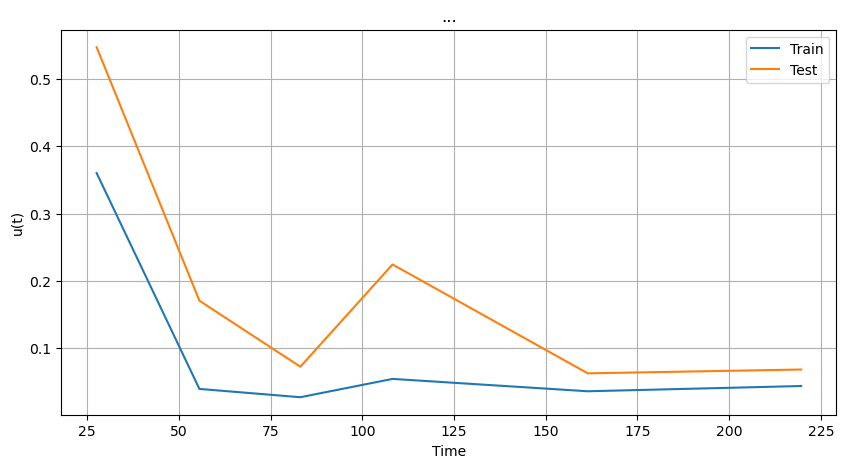

In [74]:
plt.figure(figsize=(10, 5))
plt.plot(time_elapsed_jax, mae_jax, label='Train')
plt.plot(time_elapsed_jax, mae_test_jax, label='Test')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.title("...")
plt.legend(loc ="upper right")
plt.grid(True)
plt.show()

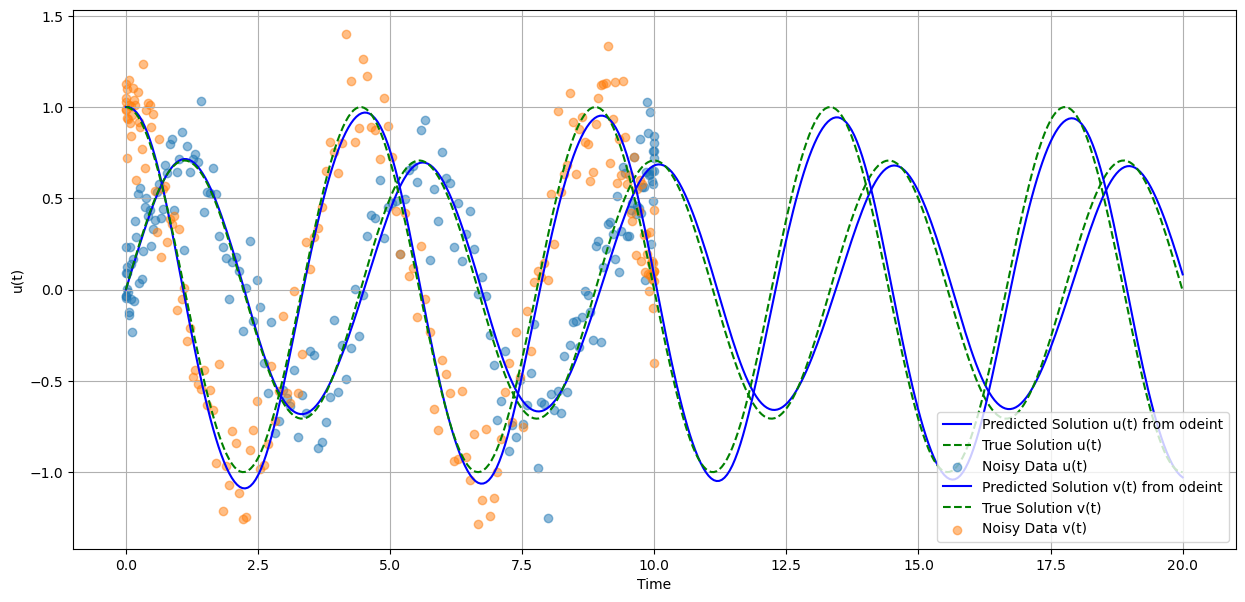

In [75]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t_test, results["jax_odeint_5"]["y_pred_test"].T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t_test, y_test.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

#plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t_test, results["jax_odeint_5"]["y_pred_test"].T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t_test, y_test.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

---

In [76]:
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [77]:
for i, max_cpu in enumerate([100, 200, 300, 400, 500, 600]):
    layer_widths = [2, 20, 2]
    
    ode_model = ODEOptimizationModel(y_noisy, t, D, layer_widths, penalty_lambda = 1000, max_iter = None, y_init = estimated_solution, max_cpu = max_cpu)
    ode_model.build_model()
    timer = ode_model.solve_model()
    
    print(f"Time elapsed: {timer}")

    # u_model, v_model = ode_model.extract_solution()

    def system_dynamics(y, t):
        u, v = y
        du_dt, dv_dt = ode_model.predict(u, v)
        return jnp.array([du_dt, dv_dt])

    initial_conditions = jnp.array([0.0, 1.0]) 
    y_pred_train = odeint(system_dynamics, initial_conditions, t)    
    
    mae_train = jnp.mean(jnp.abs(y_pred_train - y))
    
    y_pred_test = odeint(system_dynamics, initial_conditions, t_test)   
    mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test[200:]))
    
    results[f"pyomo_constr_{i}"] = {
        "mae":mae_train, "y_pred_train": y_pred_train, "time_elapsed": timer, "type": "pyomo_constr", 
        "max_cpu": max_cpu, "layer_widths": layer_widths, "penalty_lambda": 1000,
        "mae_test" : mae_test, "y_pred_test" : y_pred_test
        }

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum CPU Time Exceeded.
Time elapsed: 28.076920747756958
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum CPU Time Exceeded.
Time elapsed: 52.26529288291931
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum CPU Time Exceeded.
Time elapsed: 80.54137682914734
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum CPU Time Exceeded.
Time elapsed: 109.79412698745728
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum CPU Time Exceeded.
Time elapsed: 148.30664324760437
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum CPU Time Exceeded.
Time elapsed: 1

In [78]:
# Using list comprehension for more concise and readable code
time_elapsed_pyomo = [result["time_elapsed"] for result in results.values() if result["type"] == "pyomo_constr"]
mae_pyomo = [result["mae"] for result in results.values() if result["type"] == "pyomo_constr"]
mae_test_pyomo = [result["mae_test"] for result in results.values() if result["type"] == "pyomo_constr"]

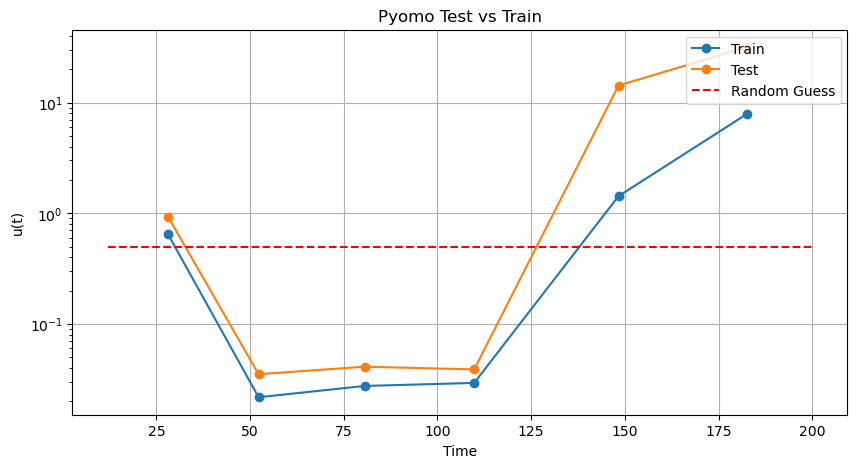

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(time_elapsed_pyomo, mae_pyomo, "o-", label='Train')
plt.plot(time_elapsed_pyomo, mae_test_pyomo, "o-", label='Test')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.title("Pyomo Test vs Train")
plt.hlines(y=0.5, xmin=12, xmax=200, colors='r', linestyles='dashed', label='Random Guess')
plt.legend(loc ="upper right")
plt.grid(True)
plt.yscale('log')
plt.show()

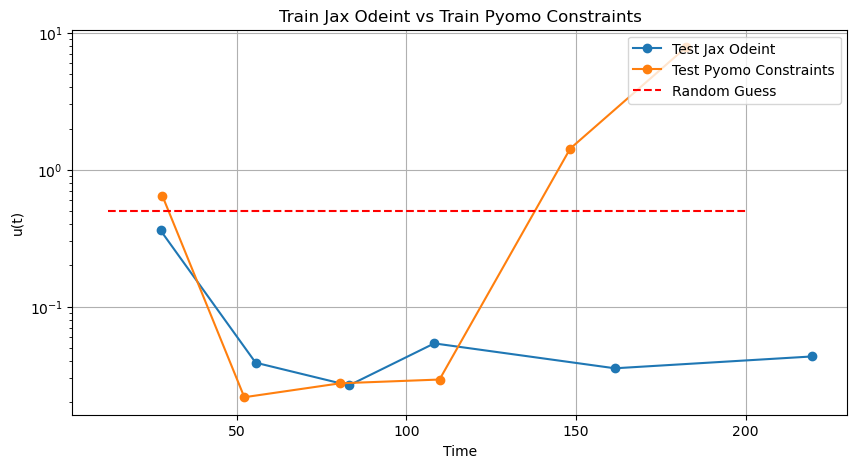

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(time_elapsed_jax, mae_jax, "o-",label='Test Jax Odeint')
plt.plot(time_elapsed_pyomo, mae_pyomo, "o-", label='Test Pyomo Constraints')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.title("Train Jax Odeint vs Train Pyomo Constraints")
plt.hlines(y=0.5, xmin=12, xmax=200, colors='r', linestyles='dashed', label='Random Guess')
plt.legend(loc ="upper right")
plt.grid(True)
plt.yscale('log')
plt.show()

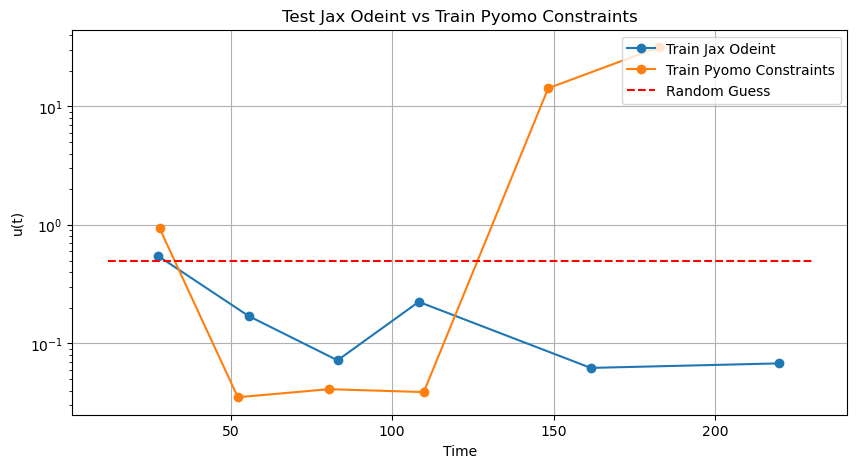

In [87]:
plt.figure(figsize=(10, 5))
plt.plot(time_elapsed_jax, mae_test_jax, "o-", label='Train Jax Odeint')
plt.plot(time_elapsed_pyomo, mae_test_pyomo, "o-", label='Train Pyomo Constraints')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.title("Test Jax Odeint vs Train Pyomo Constraints")
plt.hlines(y=0.5, xmin=12, xmax=230, colors='r', linestyles='dashed', label='Random Guess')
plt.legend(loc ="upper right")
plt.grid(True)
plt.yscale('log')
plt.show()

In [82]:
results.keys()

dict_keys(['jax_odeint_0', 'jax_odeint_1', 'jax_odeint_2', 'jax_odeint_3', 'jax_odeint_4', 'jax_odeint_5', 'pyomo_constr_0', 'pyomo_constr_1', 'pyomo_constr_2', 'pyomo_constr_3', 'pyomo_constr_4', 'pyomo_constr_5'])

---

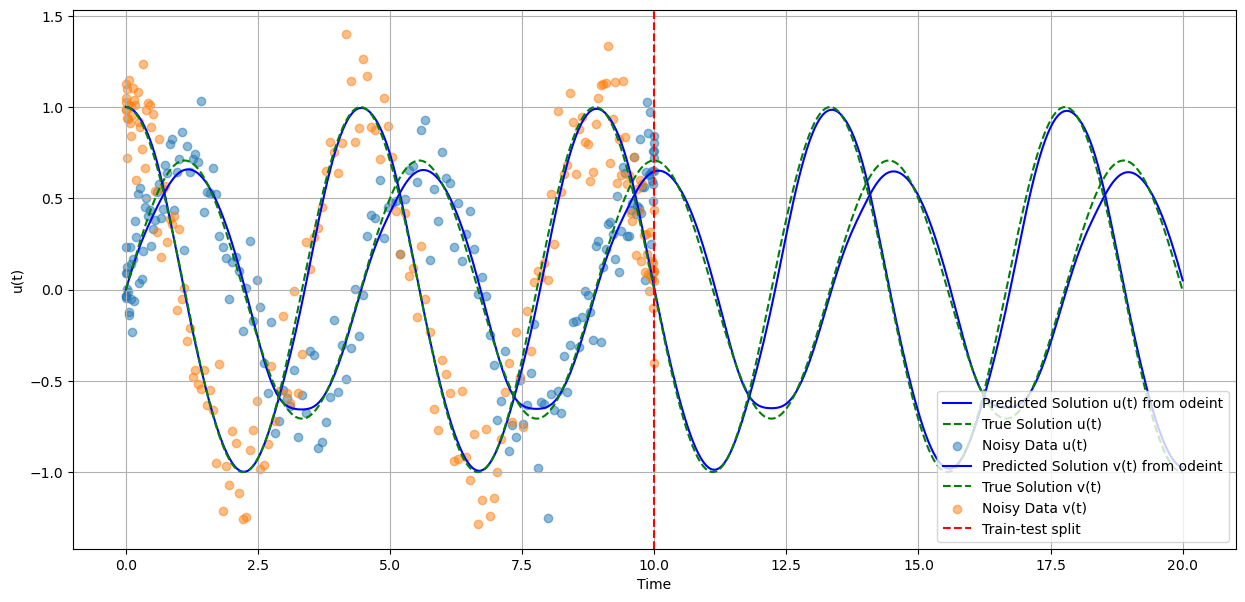

In [84]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t_test, results["pyomo_constr_3"]["y_pred_test"].T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t_test, y_test.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

#plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t_test, results["pyomo_constr_3"]["y_pred_test"].T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t_test, y_test.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [88]:
layer_widths = [2, 20, 2]

max_iter = 500
start_timer_build = time.time()
ode_model = ODEOptimizationModel(y_noisy, t, D, layer_widths, penalty_lambda = 1000, max_iter = None, y_init = estimated_solution, max_cpu = 100)
ode_model.build_model()
end_timer_build = time.time()


start_timer_solve = time.time()
ode_model.solve_model()
start_timer_solve = time.time()

# print(f"Time elapsed: {timer}")

u_model, v_model = ode_model.extract_solution()

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum CPU Time Exceeded.


In [68]:
def system_dynamics(y, t):
    u, v = y
    du_dt, dv_dt = ode_model.predict(u, v)
    return jnp.array([du_dt, dv_dt])

initial_conditions = jnp.array([0.0, 1.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t)    

mae_train = jnp.mean(jnp.abs(y_pred_train - y))

y_pred_test = odeint(system_dynamics, initial_conditions, t_test)   
mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test[200:]))